# <center>Team ZF1 Movie Recommendation 2022 Challenge</center>

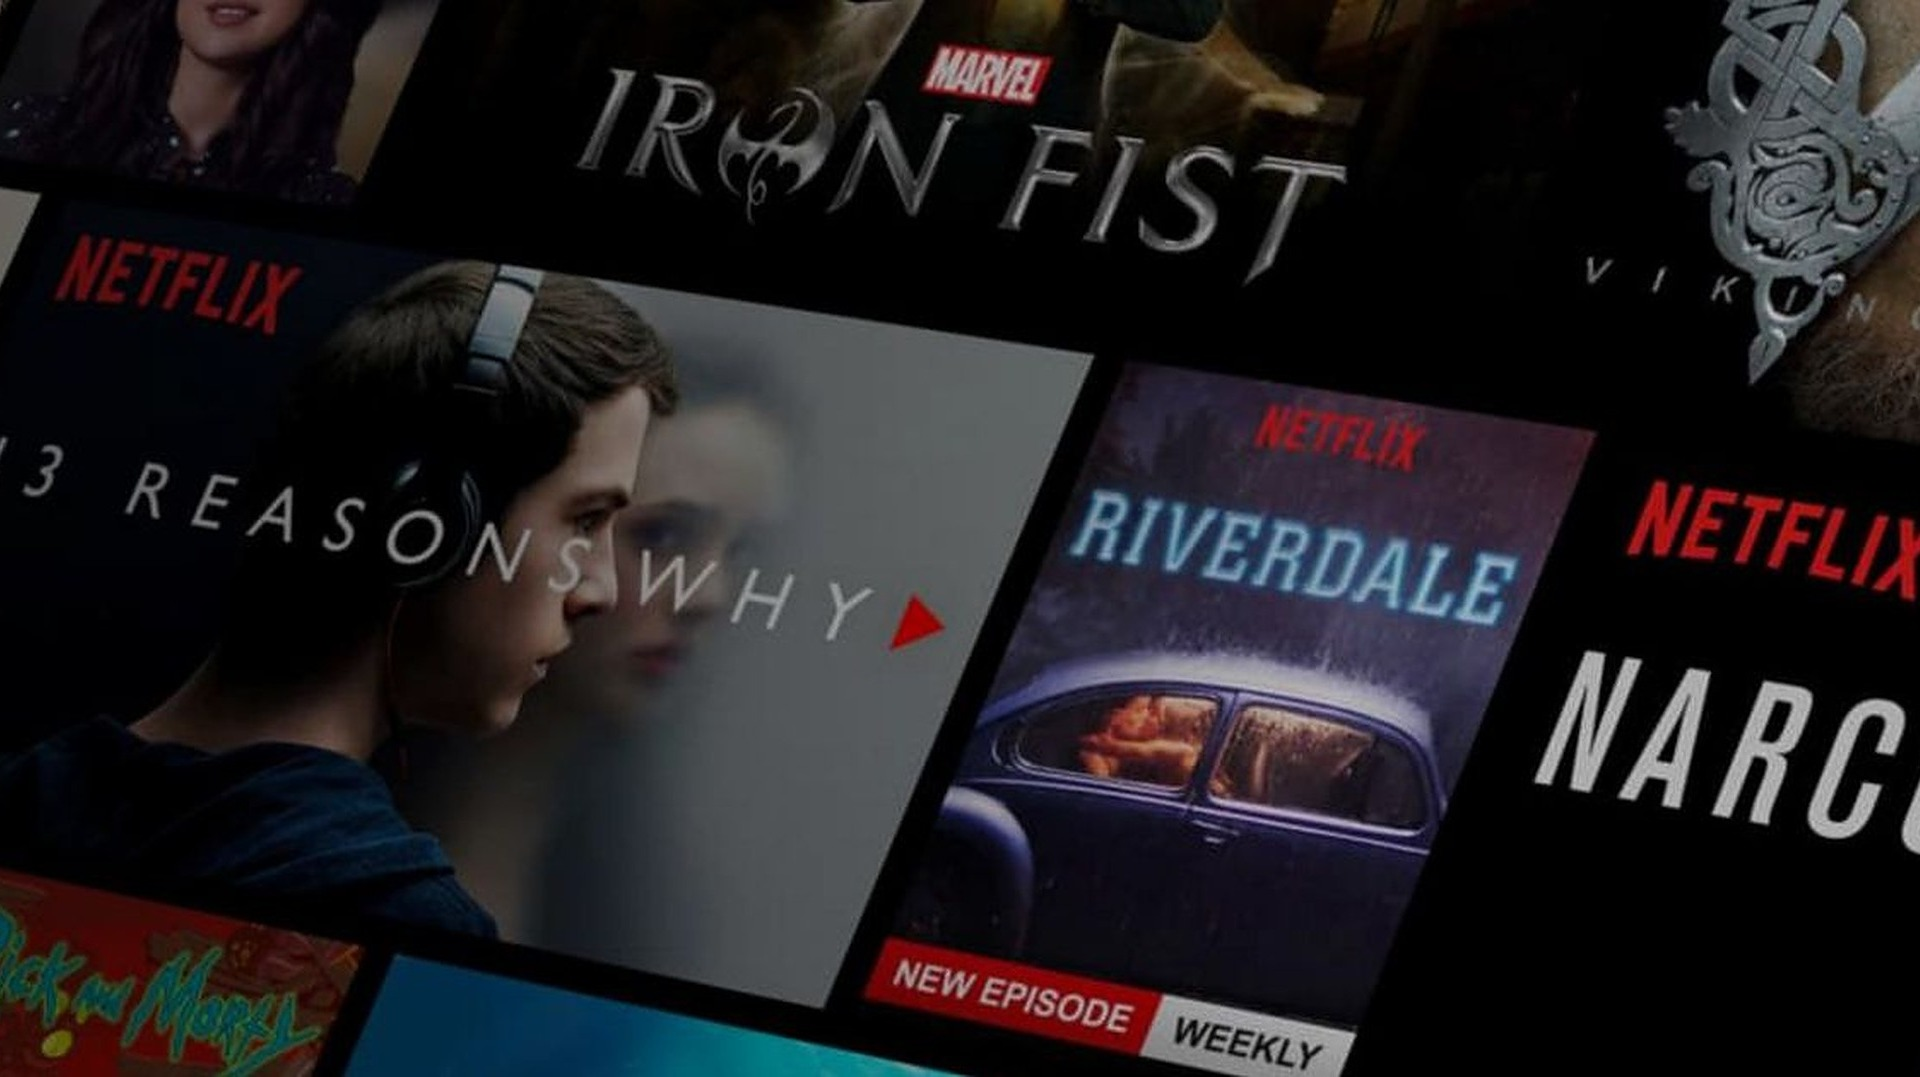

<a id='Table_Contents'></a><br>
### Table of Contents
1. [Introduction](#intro)
 * Problem Statement
 
2. [Data](#imports_data)
 * Running Experiment on Comet
 * Importing Packages
 * Loading Data
 * Dataset Description
 
3. [Exploratory Data Analysis](#EDA)
 * Movie Genres 
 * Movie Ratings
 * Movies Released Per Year
 * IMDB Data
 
4. [Data Preprocessing](#preprocessing)
 
5. [Model Building](#model)
 
 
6. [Model Evaluation](#evaluation)
 
 
7. [Hyperparameter Tuning](#tuning)
 

8. [Prediction](#prediction)
 

9. [Conclusion](#conclusion)


10. [References](#ref)



<a id='intro'></a><br>
## 1. Introduction
[Back to Table of Contents](#Table_Contents)

### Problem Statement

In today’s technology driven world, recommender systems are socially and economically critical to ensure that individuals can make optimised choices surrounding the content they engage with on a daily basis. One application where this is especially true is movie recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

The aim of this project is to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being personalised recommendations - generating platform affinity for the streaming services which best facilitates their audience's viewing.




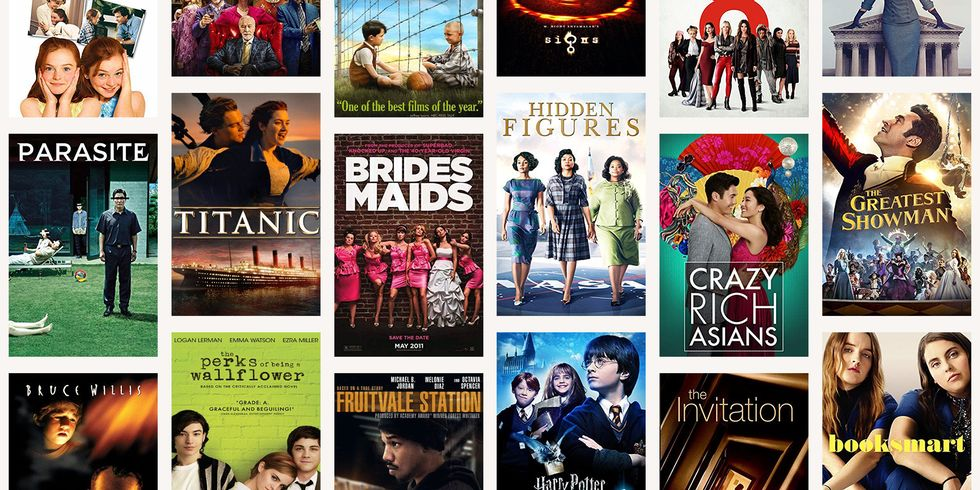

<a id='imports_data'></a><br>
## 2. Data
[Back to Table of Contents](#Table_Contents)

### Running Experiment on Comet

In [1]:
# import comet_ml 
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="mn7gOjsbMtlJODxIBDP2G0w6e",
    project_name="movie-recommendation-edsa-teamzf1",
    workspace="roceey",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/roceey/movie-recommendation-edsa-teamzf1/18a3fbf8d7e745ed8244516a993ee6bf



In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Packages

In [3]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display_html 
from IPython.core.display import HTML
from collections import defaultdict
import datetime
import re
import squarify
import os
from plotly.offline import init_notebook_mode, iplot, plot
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as pyo
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)



# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate, train_test_split
from surprise import SVD,accuracy
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

## Loading Data

We first load the data and inspect its head.

In [4]:
#data_folder = '/kaggle/input/edsa-movie-recommendation-2022/'
data_folder = 'C:/Users/Hudson/Documents/Unsupervised_learning/'

df_train = pd.read_csv(data_folder + 'train.csv')
df_test = pd.read_csv(data_folder + 'test.csv')
df_tags = pd.read_csv(data_folder + 'tags.csv')
df_movies = pd.read_csv(data_folder + 'movies.csv')
df_links = pd.read_csv(data_folder + 'links.csv')
df_imdb = pd.read_csv(data_folder + 'imdb_data.csv')
df_genome_scores = pd.read_csv(data_folder + 'genome_scores.csv')
df_genome_tags = pd.read_csv(data_folder + 'genome_tags.csv')
df_sample_submission = pd.read_csv(data_folder + 'sample_submission.csv')


In [5]:
# Show "imdb_df" dataframe
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [6]:
# Function that displays multiple dataframes in one cell
def data_overview(dataframe_list, column_names=[]):

    html_string = ''
    html_string += ('<tr>' + ''.join(f'<td style="text-align:center">{name}</td>' for name in column_names) + '</tr>')
    html_string += ('<tr>' + ''.join(f'<td style="vertical-align:top"> {df.to_html(index=True)}</td>' for df in dataframe_list)
                    +'</tr>')
    html_string = f'<table>{html_string}</table>'
    html_string = html_string.replace('table','table style="display:inline"')
    display_html(html_string, raw=True)  

In [7]:
# Display the overview of train, test, links and tags dataframes
data_overview([df_train.head(), df_test.head(), df_links.head(), df_tags.head()], 
              column_names=['Train','Test','Links','Tags'])

Train Test Links Tags 
 
 
 
 userId 
 movieId 
 rating 
 timestamp 
 
 
 
 
 0 
 5163 
 57669 
 4.0 
 1518349992 
 
 
 1 
 106343 
 5 
 4.5 
 1206238739 
 
 
 2 
 146790 
 5459 
 5.0 
 1076215539 
 
 
 3 
 106362 
 32296 
 2.0 
 1423042565 
 
 
 4 
 9041 
 366 
 3.0 
 833375837 
 
 
 
 
 
 
 userId 
 movieId 
 
 
 
 
 0 
 1 
 2011 
 
 
 1 
 1 
 4144 
 
 
 2 
 1 
 5767 
 
 
 3 
 1 
 6711 
 
 
 4 
 1 
 7318 
 
 
 
 
 
 
 movieId 
 imdbId 
 tmdbId 
 
 
 
 
 0 
 1 
 114709 
 862.0 
 
 
 1 
 2 
 113497 
 8844.0 
 
 
 2 
 3 
 113228 
 15602.0 
 
 
 3 
 4 
 114885 
 31357.0 
 
 
 4 
 5 
 113041 
 11862.0 
 
 
 
 
 
 
 userId 
 movieId 
 tag 
 timestamp 
 
 
 
 
 0 
 3 
 260 
 classic 
 1439472355 
 
 
 1 
 3 
 260 
 sci-fi 
 1439472256 
 
 
 2 
 4 
 1732 
 dark comedy 
 1573943598 
 
 
 3 
 4 
 1732 
 great dialogue 
 1573943604 
 
 
 4 
 4 
 7569 
 so bad it's good 
 1573943455

In [8]:
# Display the overview of movies, genome_tags and genome_scores dataframes
data_overview([df_movies.head(), df_genome_tags.head(), df_genome_scores.head()], 
                      column_names=['Movies','Genome Tags','Genome Scores'])

Movies Genome Tags Genome Scores 
 
 
 
 movieId 
 title 
 genres 
 
 
 
 
 0 
 1 
 Toy Story (1995) 
 Adventure|Animation|Children|Comedy|Fantasy 
 
 
 1 
 2 
 Jumanji (1995) 
 Adventure|Children|Fantasy 
 
 
 2 
 3 
 Grumpier Old Men (1995) 
 Comedy|Romance 
 
 
 3 
 4 
 Waiting to Exhale (1995) 
 Comedy|Drama|Romance 
 
 
 4 
 5 
 Father of the Bride Part II (1995) 
 Comedy 
 
 
 
 
 
 
 tagId 
 tag 
 
 
 
 
 0 
 1 
 007 
 
 
 1 
 2 
 007 (series) 
 
 
 2 
 3 
 18th century 
 
 
 3 
 4 
 1920s 
 
 
 4 
 5 
 1930s 
 
 
 
 
 
 
 movieId 
 tagId 
 relevance 
 
 
 
 
 0 
 1 
 1 
 0.02875 
 
 
 1 
 1 
 2 
 0.02375 
 
 
 2 
 1 
 3 
 0.06250 
 
 
 3 
 1 
 4 
 0.07575 
 
 
 4 
 1 
 5 
 0.14075

### Dataset Description 

The supplied dataset comprises the following:

* train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.
* test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
* tags.csv - User assigned for the movies within the dataset.
* movies.csv - Contains a database of movies categorized into different genres.
* genome_scores.csv - A score mapping the strength between movies and tag-related properties.
* genome_tags.csv - User assigned tags for genome-related scores.
* imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
* links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.

Below is additional information regarding the various datasets:

#### Ratings Data File Structure (train.csv)
Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

#### Tags Data File Structure (tags.csv)
Each line of this file after the header row represents one tag applied to one movie by one user.
Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag are determined by each user.

#### Movies Data File Structure (movies.csv)
Genres are a pipe-separated list, and include Action, Adventure, Animation, Children's, Comedy, Crime, Documentary,
Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western.

#### Links Data File Structure (links.csv)
Identifiers that can be used to link to other sources of movie data are contained in the file links.csv. 

#### Tag Genome (genome-scores.csv and genome-tags.csv)
The tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). 



<a id='EDA'></a><br>
## 3. Exploratory Data Analysis
[Back to Table of Contents](#Table_Contents)


In this section we perform exploratory data analysis on the data to gain a better understanding of the features and the relationships between them. We will employ both statistical and visualisation methods of EDA.

### Movie Genres

We start by conducting an analysis of the movies dataframe to find out the most and least common genres. 

In [9]:
# Top 10 genres by volume:
df_genres = df_movies["genres"].value_counts()
df_genres.head(10)

Drama                   9056
Comedy                  5674
(no genres listed)      5062
Documentary             4731
Comedy|Drama            2386
Drama|Romance           2126
Horror                  1661
Comedy|Romance          1577
Comedy|Drama|Romance    1044
Drama|Thriller           933
Name: genres, dtype: int64

In [10]:
# Bottom 10 genres by volume:
df_genres = df_movies["genres"].value_counts()
df_genres.tail(10)

Action|Adventure|Fantasy|Romance|IMAX               1
Crime|Drama|Thriller|Western                        1
Fantasy|Romance|Thriller|IMAX                       1
Adventure|Fantasy|Horror|Romance|Sci-Fi|Thriller    1
Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX     1
Action|Adventure|Crime|Fantasy                      1
Drama|Film-Noir|Musical|Thriller                    1
Action|Drama|Horror|Mystery                         1
Adventure|Comedy|Sci-Fi|Thriller|War                1
Comedy|Horror|Mystery|Sci-Fi|Western                1
Name: genres, dtype: int64

Interestingly, we observe that the top genres by volume only have one or two genre types, whereas the bottom genres consist of multiple genres. This is probably because these movies are a lot more niche and uncommon, resulting in a lower volume in the dataset.


Next we plot the individual genres from the most common to the least common.

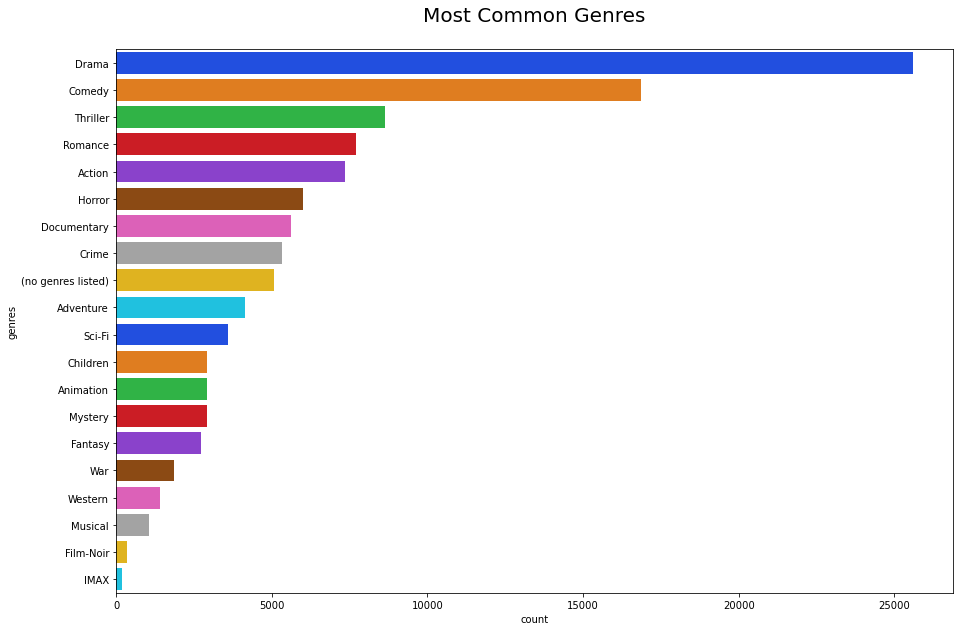

In [11]:
# Create dataframe containing only the movieId and genres

movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most Common Genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='bright')
plt.show()

### Movie Ratings

Next we inspect the train dataframe which consists of ratings data.

#### Movie Ratings Distribution
We investigate how ratings (0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5) are distributed in the movies data.

In [12]:
# Ratings distribution
data = df_train['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in 
                       (data.values / df_train.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = ['aliceblue']),
               y = data.values
               )
# Create layout
layout = dict(title = 'Distribution of Movie Ratings'.format(df_train.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

From the figure above we observe that 4.0 is the most commonly score, with 26.5% of the movies in the dataframe assigned that score. This could be explained by the fact that users tend to only rate movies they enjoyed and avoid rating movies they dont like. If a user doesn't enjoy a movie, it is quite unlikely that they will watch it up until the end and rate it. This is why there are few low ratings as compared to high ratings.

We also observe that half scores (0.5, 1.5, 2.5, 3.5 and 4.5) are less commonly used than integer score values. We don't know if this is because users prefer to rate movies with integer values or if it's because half scores were introduced after the original scoring system was already in use, leading to a decreased volume in a dataset with ratings from 1995. 

#### Top Rated Movies

In [13]:
def popular_movies(df1,df2):
    
    """
    A function that returns popular movies based on the average ratings.
    
    """
   
   
    rating = pd.DataFrame(df1.groupby('movieId')['rating'].mean())
    
    rating['ratings_count'] = pd.DataFrame(df1.groupby('movieId')['rating'].count())
    rating=rating.sort_values(by=['ratings_count','ratings_count'],ascending=False).reset_index()
    
    
    inner_join = pd.merge(rating,df2,on ='movieId',how ='inner')
    popular_movies = inner_join[['title','rating','ratings_count']].rename(columns={"rating": "rating"})
    
    return popular_movies

In [14]:
# Top 10 most popular movies
popular_movies(df_train, df_movies).head() 

,title,rating,ratings_count
0,"Shawshank Redemption, The (1994)",4.417624,32831
1,Forrest Gump (1994),4.047216,32383
2,Pulp Fiction (1994),4.195097,31697
3,"Silence of the Lambs, The (1991)",4.144172,29444
4,"Matrix, The (1999)",4.154253,29014


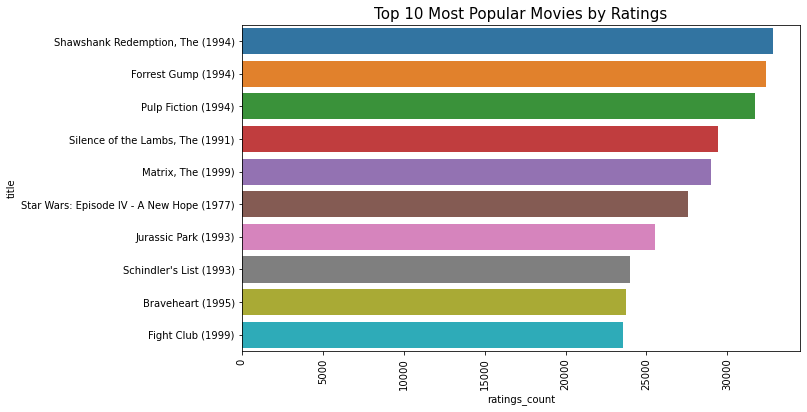

In [15]:
df = popular_movies(df_train, df_movies)


plt.figure(figsize = (10,6))#Bar plot of most popular movies by ratings
ax=sns.barplot(y='title', x='ratings_count', data=df.head(10))
ax.set_title('Top 10 Most Popular Movies by Ratings',fontsize=15)
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

From the above plot we observe that the most poular movie of all time is Shawshank Redemption that was released in 1994 and that has an average rating of approximately 4.42. 

#### Number of Ratings per Movie
We explore how many movies receive a number of ratings and visualize this in a plot.

In [16]:
# Number of ratings per movie
data = df_train.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution of Number of Ratings Per Movie',
                   xaxis = dict(title = 'Number of Ratings Per movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We observe that the count of number of ratings per movie is on a decreasing scale.

### Movies Released Per Year

We explore how many movies have been released each year using the movies dataset.

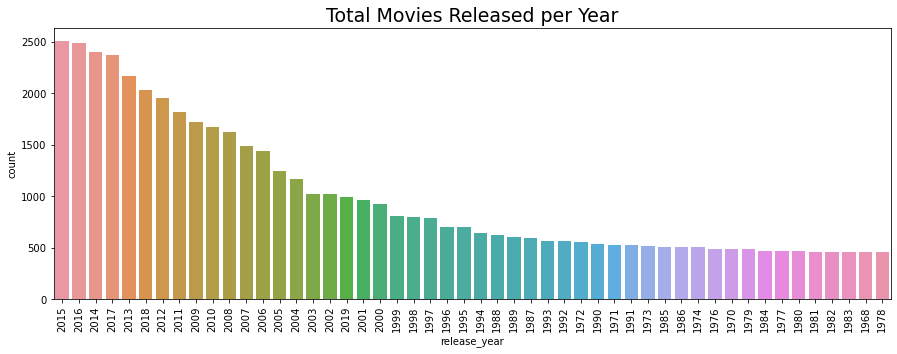

In [17]:
# Total movies released in each year using a count plot.
df_movies['release_year'] = df_movies['title'].str[-5:-1]
figure= plt.subplots(figsize=(15, 5))
axes=sns.countplot(x = df_movies['release_year'], order = df_movies['release_year'].value_counts()[0:50].index)
axes.set_title('Total Movies Released per Year',fontsize=19)
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

We observe that as the years progress, the amount of movies being released have significantly increased with the most movies released in 2015 and 2016. The number of movies being released per year have definitely shot up since the year 2000.

### IMDB Data

Here we explore the IMBD data to learn more about the content of the movies and the people who worked on them.

#### Top Actors by Volume

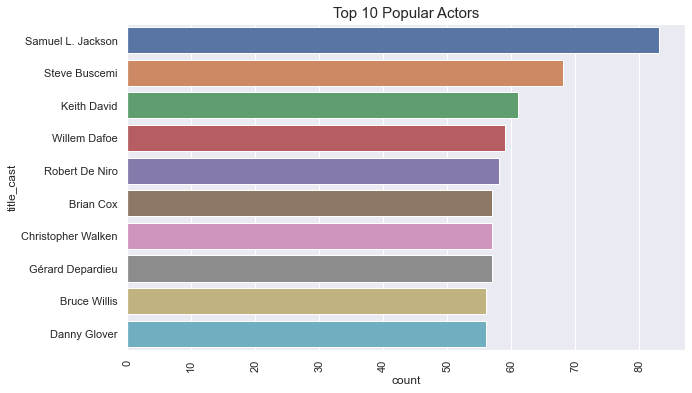

In [24]:
df_imdb_copy = df_imdb.copy()
df_imdb_copy['title_cast']=df_imdb_copy['title_cast'].str.split('|') #spliting the title cast into a list
df_imdb_copy['plot_keywords']=df_imdb_copy['plot_keywords'].str.split('|') #spliting the Key words into a list
plt.figure(figsize = (10,6))
title_cast = df_imdb_copy['title_cast'].explode()
ax=sns.countplot(y=title_cast, order = title_cast.value_counts().index[:10])
ax.set_title('Top 10 Popular Actors',fontsize=15)
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

#### Top 10 Most Popular Movie Directors

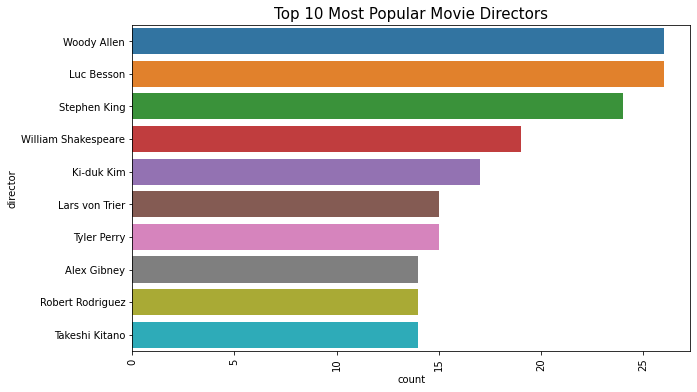

In [19]:
#Plotting top 10 movie directors using a count-plot
plt.figure(figsize = (10,6))
director=df_imdb_copy['director'].explode()
axes=sns.countplot(y=director, order = director.value_counts().index[1:11])
axes.set_title('Top 10 Most Popular Movie Directors',fontsize=15)
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

In [20]:
# Top 5 plot keywords by volume:
keywords_df = df_imdb["plot_keywords"].value_counts()
keywords_df.head()

Documentary                         19
f rated                             16
Action                              16
Comedy                              12
stand up special|stand up comedy     9
Name: plot_keywords, dtype: int64

#### Wordcloud of Plot Keywords

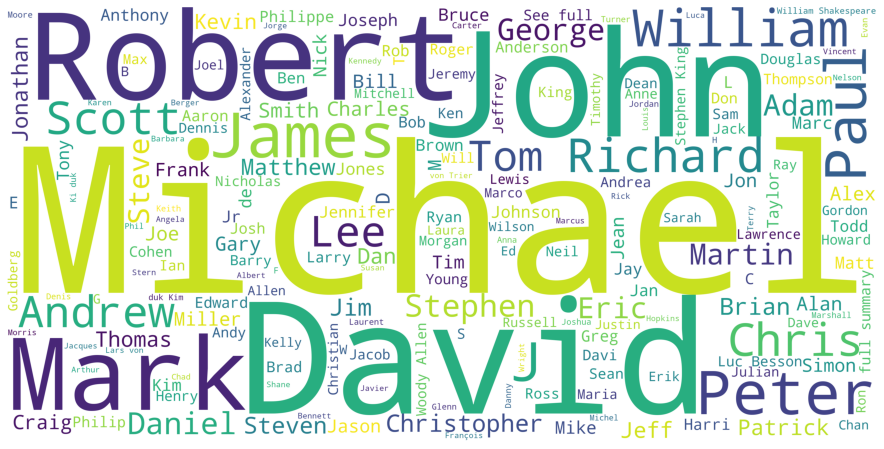

In [21]:
# Creating a wordcloud of the movie titles to view the most popular actors withtin the word cloud


df_imdb_copy['director']=df_imdb_copy['director'].fillna("").astype('str')
title_corpus = ' '.join(df_imdb_copy['director'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

#### Runtime Distribution

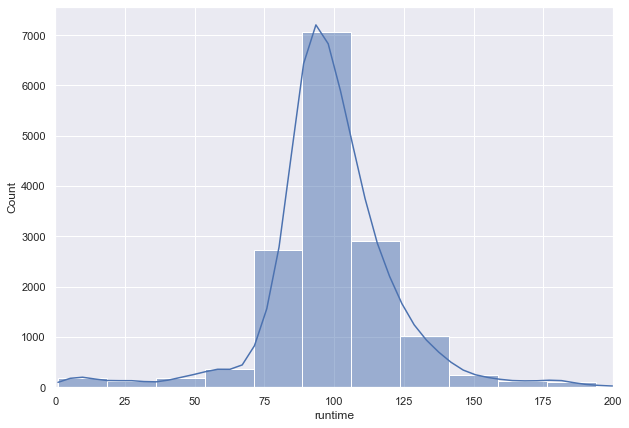

In [22]:

# Plot the genres from most common to least common
sns.set(style="darkgrid")
sns.set(rc = {'figure.figsize':(10,7)})
sns.histplot(data=df_imdb, x="runtime", bins=50, kde=True)
plt.xlim(0, 200)
plt.show()

From the histogram we observe that movie runtime is normally distributed with average runtime being 100 minutes.

#### Top Longest Movies
We merge the imdb and the movies dataframes to find the longest movies in the dataset.

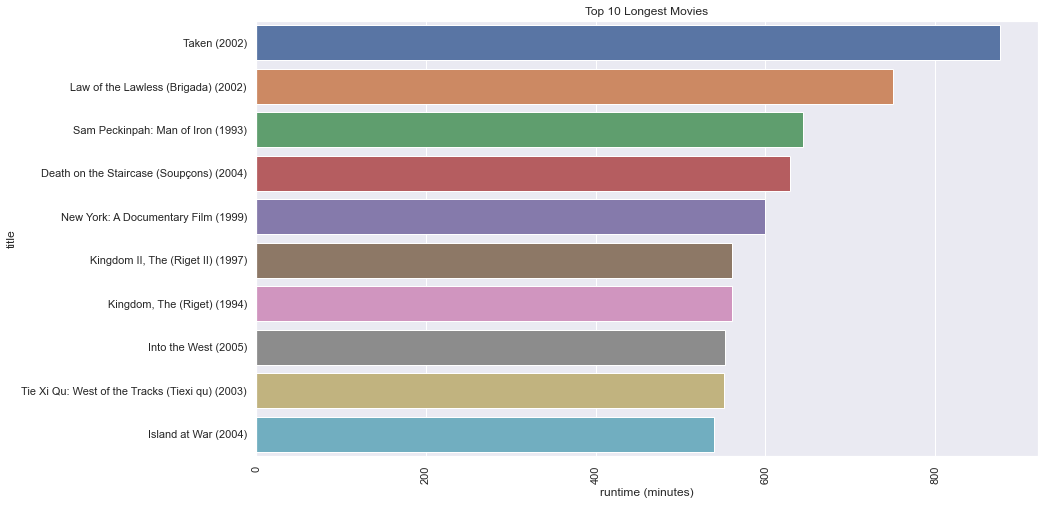

In [30]:
df_movimdb = pd.merge(left=df_movies, right=df_imdb, left_on='movieId', right_on='movieId')
df_movimdb_copy = df_movimdb.copy()
df_movimdb_copy = pd.DataFrame(df_movimdb_copy.sort_values(by=['runtime'],ascending = False))
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.barplot(y="title", x="runtime", data=df_movimdb_copy.head(10))
ax.set_title('Top 10 Longest Movies')
ax.set_ylabel('title')
ax.set_xlabel('runtime (minutes)')
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

#### Movies Budget


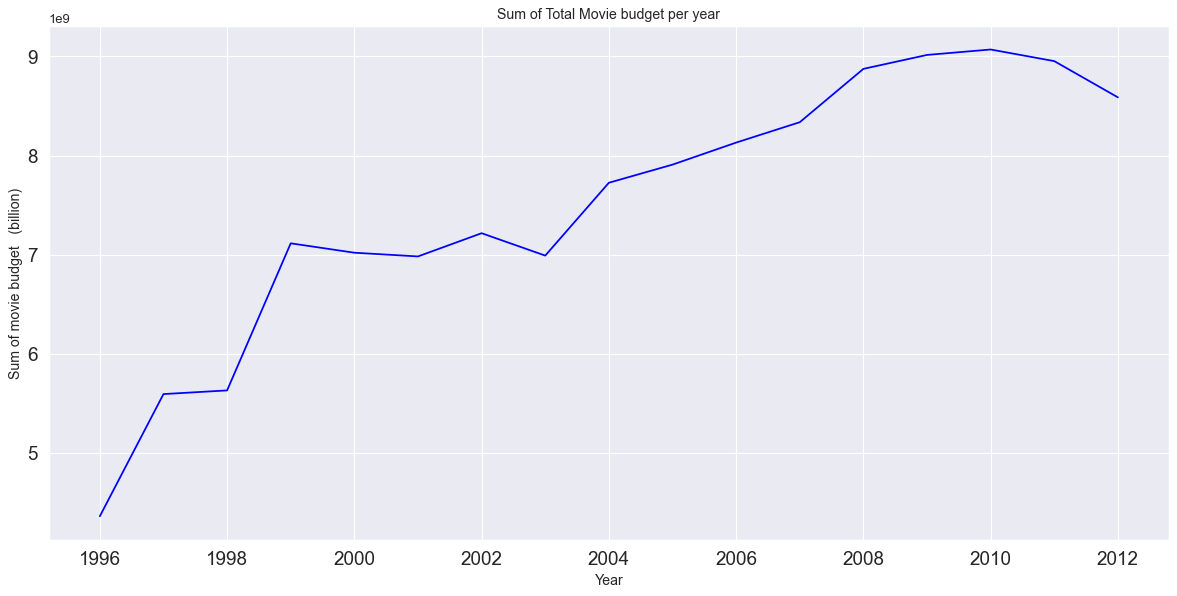

In [34]:

movies_budget = pd.DataFrame(df_movimdb[['movieId', 'title','budget']],columns=['movieId', 'title','budget'])

movies_budget= movies_budget[movies_budget['title'].notnull()]

movies_budget['budget'].replace('', np.nan, inplace=True)
movies_budget.dropna(subset=['budget'], inplace=True)

# Split title seperated by "|" and create a list containing the title allocated to each movie
movies_budget.title = movies_budget.title.apply(lambda x: int(re.findall(r"\d\d\d\d",x).pop(0)))
movies_budget.budget = movies_budget.budget.apply(lambda x: int(re.sub("[^0-9]", "", x)) if str(x)[:1] =='$' else None)
movies_budget = movies_budget[movies_budget['budget'].notnull()]
movies_budget =movies_budget[movies_budget['title'] > 1888]
movies_budget =movies_budget[movies_budget['title'] <= 2021]
movies_budget =movies_budget[movies_budget['title'] > 1995]
movies_budget =movies_budget[movies_budget['title'] <= 2012]
Total_movie_budget = movies_budget.groupby("title")["budget"].sum().reset_index(name="Sum of movie budget")
fig,ax = plt.subplots(figsize=(17, 8), dpi=85)

Total_movie_budget.plot.line(x='title',y='Sum of movie budget', ax=ax, color='blue', 
                             legend=False, fontsize=16)
ax.set_title('Sum of Total Movie budget per year')
ax.set_xlabel('Year')
ax.set_ylabel('Sum of movie budget   (billion)')

plt.show()

We observe that the amount of money spent in movie production per year has increased over the years.

#### Top Budget Movies

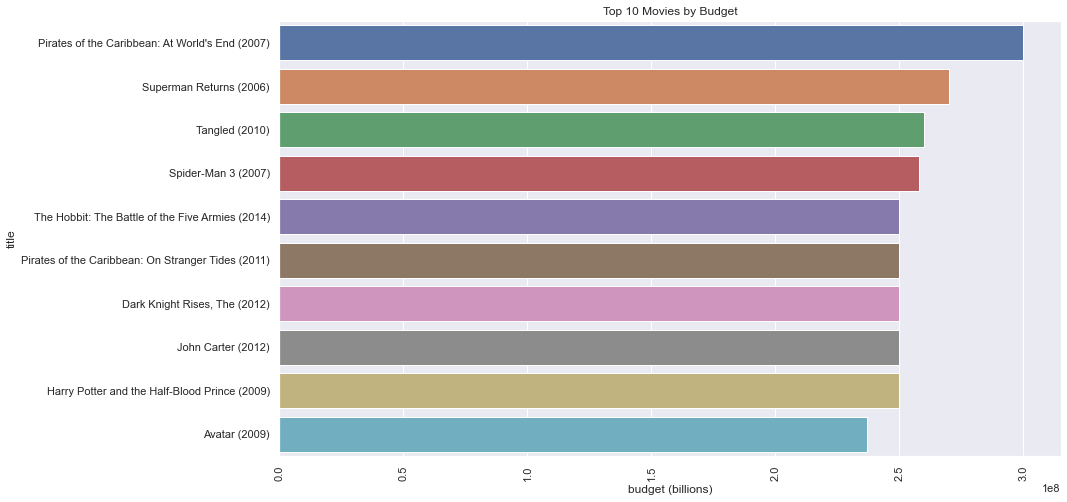

In [28]:
#make a plot which contain top 20 highest budget movies.

df_movimdb_copy = df_movimdb.copy()
df_movimdb_copy.budget = df_movimdb_copy.budget.apply(lambda x: int(re.sub("[^0-9]", "", x)) if str(x)[:1] =='$' else None)
df_movimdb_copy = df_movimdb_copy[df_movimdb_copy['budget'].notnull()]
df_movimdb_copy = pd.DataFrame(df_movimdb_copy.sort_values(by=['budget'],ascending = False))
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.barplot(y="title", x="budget", data=df_movimdb_copy.head(10))
ax.set_title('Top 10 Movies by Budget')
ax.set_ylabel('title')
ax.set_xlabel('budget (billions)')
sns.color_palette('bright')
plt.xticks(rotation=90)
plt.show()

## Modelling 

In this section the models to be used in building the recommender system will be explored. They will incude both Content based or Collabrative methods.

In [ ]:
data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']], Reader())

In [ ]:
train_set, test_set = train_test_split(data, test_size=0.20)

In [ ]:
svd=SVD(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)
svd.fit(train_set)

In [ ]:
# Make predictions
test_pred= svd.test(test_set)

In [ ]:
#Evaluate model performance
rsme_collabo = accuracy.rmse(test_pred,verbose=True)

## Hyperparameter Tuning 
 
Hyperparameter tuning is the process of determining the right combination of hyperparameters that allows the model to maximize model performance. Setting the correct combination of hyperparameters is the only way to extract the maximum performance out of models.

We hypertune the SVD algorithm model as follows


In [ ]:
# Define search grid
param_grid = {'n_epochs': [40, 45,50], 'init_std_dev' : [0.02,0.05], 'n_factors' : [200,250]}

# Instatiate gridsearch instance
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=2)

# Run gridsearch
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
svd=SVD(n_epochs = 50, n_factors = 250, init_std_dev = 0.05, random_state=42)
svd.fit(train_set)

In [ ]:
#Predicting the rating for each user and movie
ratings=[]
for x,y in df_test.itertuples(index=False):
    output=svd.predict(x,y)
    ratings.append(output)
    
output_df=pd.DataFrame(ratings)[['uid','iid','est']]
output_df['ID']=output_df['uid'].astype(str) + '_' + output_df['iid'].astype(str)
output_df=output_df[['ID','est']]
output_df.head()

## Create submission file

In [ ]:
#Creating the "results" dataframe and convert to csv
results = pd.DataFrame({"Id":output_df['ID'],"rating": output_df['est']})
results.to_csv("SVD.csv", index=False)

In [ ]:
submission = pd.DataFrame({'id': results.Id, 'rating': results.rating})
submission.to_csv('submission.csv', index=False)